In [110]:
from mne import read_epochs, pick_types
import os.path as op
import numpy as np
import nibabel as nb
import pandas as pd
from trimesh import Trimesh
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib_surface_plotting import plot_surf
from mne.time_frequency import psd_array_multitaper, psd_array_welch
from fooof import FOOOFGroup
from fooof.sim.gen import gen_aperiodic
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [172]:
def get_layer(V, F, surface_index, n_surfs):
    """Retrieve the vertices and faces corresponding to a specific surface layer.

    Args:
        V (numpy.ndarray): Array of vertices representing the entire mesh.
        F (numpy.ndarray): Array of faces representing the entire mesh.
        surface_index (int): Index of the surface layer to retrieve.
        n_surfs (int): Total number of surface layers in the mesh.

    Returns:
        tuple: A tuple containing the surface vertices and faces.
        
    """
    num_vertices_per_surface = len(V) // n_surfs
    
    start_vertex_index = surface_index * num_vertices_per_surface
    end_vertex_index = start_vertex_index + num_vertices_per_surface
    
    mesh=Trimesh(V, F, process=False, validate=False)
    verts_to_keep=np.zeros(V.shape[0])
    verts_to_keep[start_vertex_index:end_vertex_index]=1
    mesh.update_vertices(verts_to_keep.astype(bool))

    return mesh.vertices, mesh.faces

def compute_rel_power(power, freqs):
    power = gaussian_filter(power, sigma=[1.5, 2])

    if np.min(power[:]) < 0:
        power = power - np.min(power[:])
    rel_power = np.zeros(power.shape)
    for freq in range(len(freqs)):
        rel_power[:, freq] = (power[:, freq] - np.min(power[:, freq])) / (
                    np.max(power[:, freq]) - np.min(power[:, freq]))

    return rel_power

def get_crossover(freqs,rel_per_power,rel_aper_power):
    n_chans=rel_per_power.shape[0]
    ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
    g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]
    ab_rel_pow = np.mean(rel_per_power[:, ab_idx], axis=1)
    g_rel_pow = np.mean(rel_aper_power[:, g_idx], axis=1)
    crossovers = detect_crossing_points(ab_rel_pow, g_rel_pow)
    assert(len(crossovers)<=2)
    if len(crossovers) > 1:
        dist1 = np.min([crossovers[0], n_chans - crossovers[0]])
        dist2 = np.min([crossovers[1], n_chans - crossovers[1]])
        if dist1 > dist2:
            crossover = crossovers[0]
        else:
            crossover = crossovers[1]
    else:
        crossover = crossovers[0]
    return crossover

def detect_crossing_points(ab_rel_pow, g_rel_pow):
    crossing_points = []

    # Iterate through the series
    for i in range(1, len(ab_rel_pow)):
        # Check if the series cross each other
        if (ab_rel_pow[i] > g_rel_pow[i] and ab_rel_pow[i - 1] < g_rel_pow[i - 1]) or \
                (ab_rel_pow[i] < g_rel_pow[i] and ab_rel_pow[i - 1] > g_rel_pow[i - 1]):
            crossing_points.append(i)

    return crossing_points

def compute_csd(surf_tcs, times, mean_dist, n_surfs):
    # Compute CSD
    nd=1;
    spacing=mean_dist*10**-3

    csd=np.zeros((n_surfs, surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi=surf_tcs[:,t]
        csd[0,t]=surf_tcs[0,t]
        csd[1,t]=surf_tcs[1,t]
        for z in range(2,n_surfs-3):
            csd[z,t]=(phi[z+2]-2*phi[z]+phi[z-2])/((nd*spacing)**2)
        csd[-2,t]=surf_tcs[-2,t]
        csd[-1,t]=surf_tcs[-1,t]            
    
    return csd

def smooth_csd(csd, n_surfs):
    # interpolate CSD in space
    y = np.linspace(0,n_surfs-1,n_surfs)
    Yi=np.linspace(0,n_surfs-1,500)
    
    f=interp1d(y,csd,kind='cubic',axis=0)
    csd_smooth=f(Yi)
    
    csd_smooth=savgol_filter(csd_smooth, 51, 3, axis=1)
    
    return csd_smooth

In [160]:
peak_idx=1200

11 surfaces, 32166 vertices per surface


/home/bonaiuto/laminar_erf/matplotlib_surface_plotting.py:10: RuntimeWarning: invalid value encountered in true_divide
  arr[:, 0] /= lens
/home/bonaiuto/laminar_erf/matplotlib_surface_plotting.py:11: RuntimeWarning: invalid value encountered in true_divide
  arr[:, 1] /= lens
/home/bonaiuto/laminar_erf/matplotlib_surface_plotting.py:12: RuntimeWarning: invalid value encountered in true_divide
  arr[:, 2] /= lens


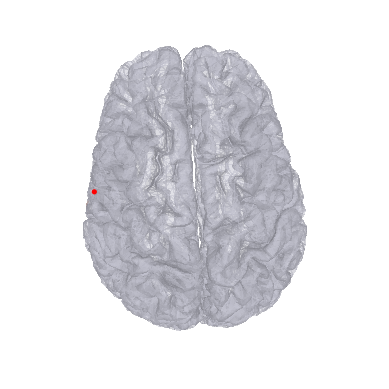

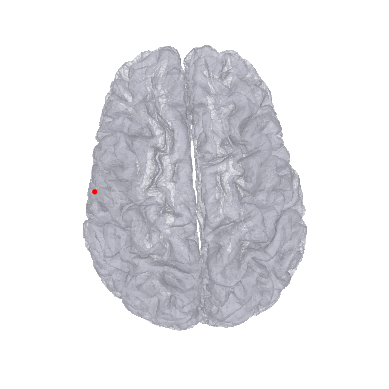

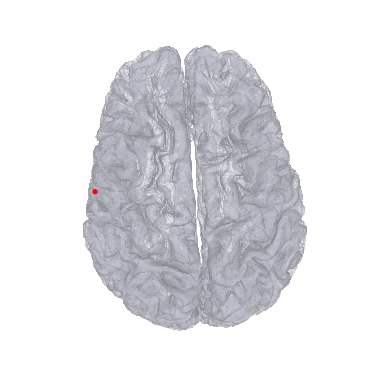

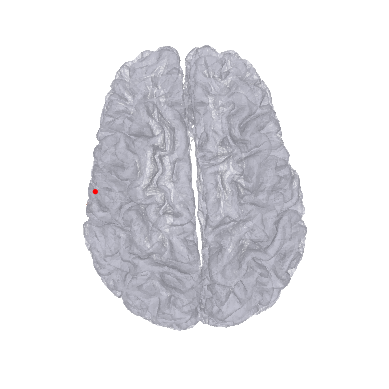

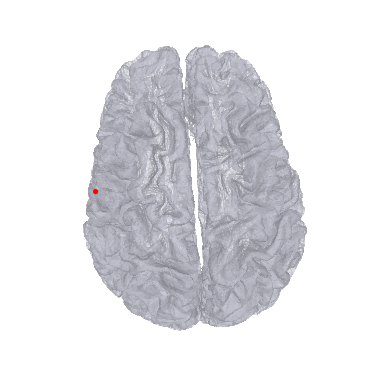

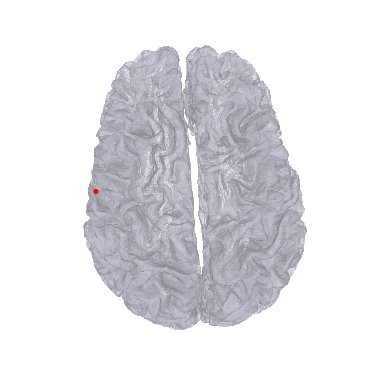

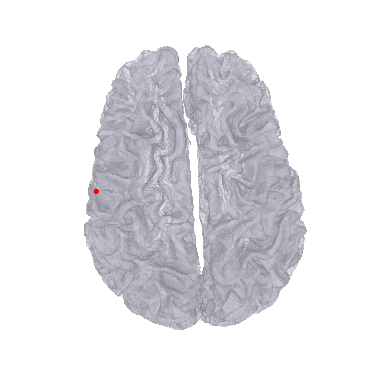

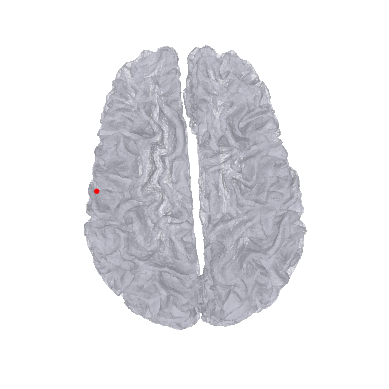

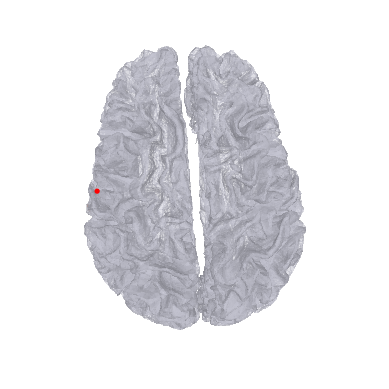

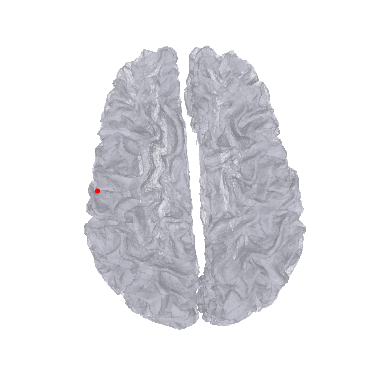

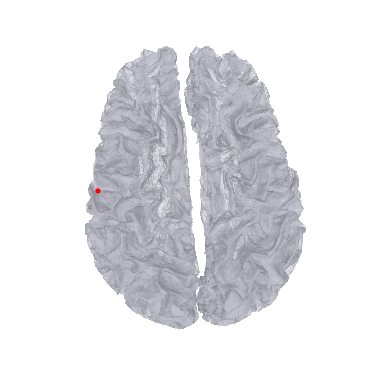

In [161]:
multilayer_fname='/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/multilayer_11.ds.link_vector.nodeep.gii'
# Load multilayer surface
multilayer_surf=nb.load(multilayer_fname);
multilayer_vertices, multilayer_faces = multilayer_surf.darrays[0].data, multilayer_surf.darrays[1].data

n_surfs=11
verts_per_surf=int(multilayer_vertices.shape[0]/n_surfs)
print('{} surfaces, {} vertices per surface'.format(n_surfs,verts_per_surf))

for i in range(n_surfs):
    pial_vertices, pial_faces = get_layer(multilayer_vertices, multilayer_faces, i, n_surfs)
    rotate = [0]
    x_rotate = 0
    fig = plt.figure(facecolor='white')
    # Plot inversion result
    ax = plt.subplot(1, 1, 1, xlim=[-.98, +.98], ylim=[-.98, +.98],
                     aspect=1, frameon=False,
                     xticks=[], yticks=[])
    overlay = np.zeros(pial_vertices.shape[0])
    overlay[0] = 10
    plot_surf(vertices=pial_vertices, faces=pial_faces, overlay=overlay, rotate=rotate, x_rotate=x_rotate,
              ax=ax, colorbar=False, cmap='jet', alpha_colour=(overlay > 0).astype(int), vmin=0, vmax=4,
              transparency=.5, coords=[pial_vertices[peak_idx,:]], coord_size=0.01)    
    


In [162]:
peak_coord=np.zeros((n_surfs,3))
for i in range(n_surfs):
    peak_coord[i,:]=multilayer_vertices[i*verts_per_surf+peak_idx,:]
print('Pial coord={}'.format(peak_coord[-1,:]))
dists=np.sqrt(np.sum((peak_coord[1:,:]-peak_coord[0:-1,:])**2,axis=1))
print('Inter-surface distances={}'.format(dists))
mean_dist=np.mean(dists)
print('Mean distance={}'.format(mean_dist))

Pial coord=[-34.51654053  28.08881378  31.37838554]
Inter-surface distances=[0.40566933 0.39266762 0.39262823 0.3926001  0.39257784 0.39254872
 0.39252039 0.39249394 0.39253825 0.38797963]
Mean distance=0.39342240569715137


In [163]:
MU=pd.read_csv('/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/inverted/MU_spm-converted_no_filter_autoreject-sub-001-ses-01-001-motor-epo.tsv', sep="\t", header=None).values

In [164]:
# Load data
epo_path = op.join('/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/ses-01/autoreject-sub-001-ses-01-001-motor-epo.fif')
epochs = read_epochs(epo_path, verbose=False, preload=True)
#epochs = epochs.filter(0,30)
meg_chans=pick_types(epochs.info,meg=True, ref_meg=False)
epo_data=epochs.get_data()
epo_data=epo_data[:,meg_chans,:]

Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Effective window size : 3.333 (s)
Running FOOOFGroup across 11 power spectra.


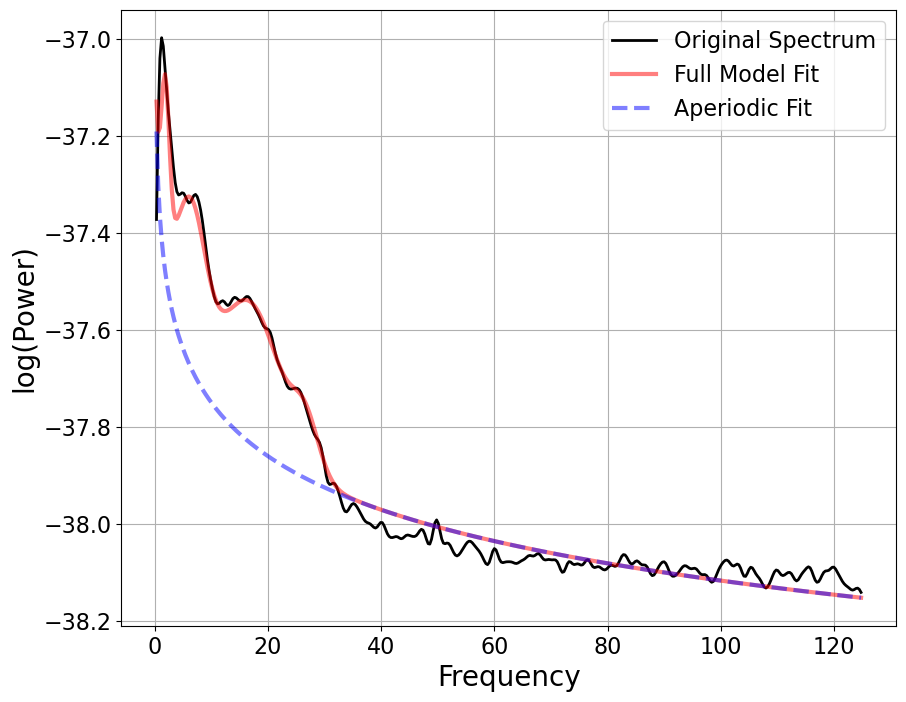

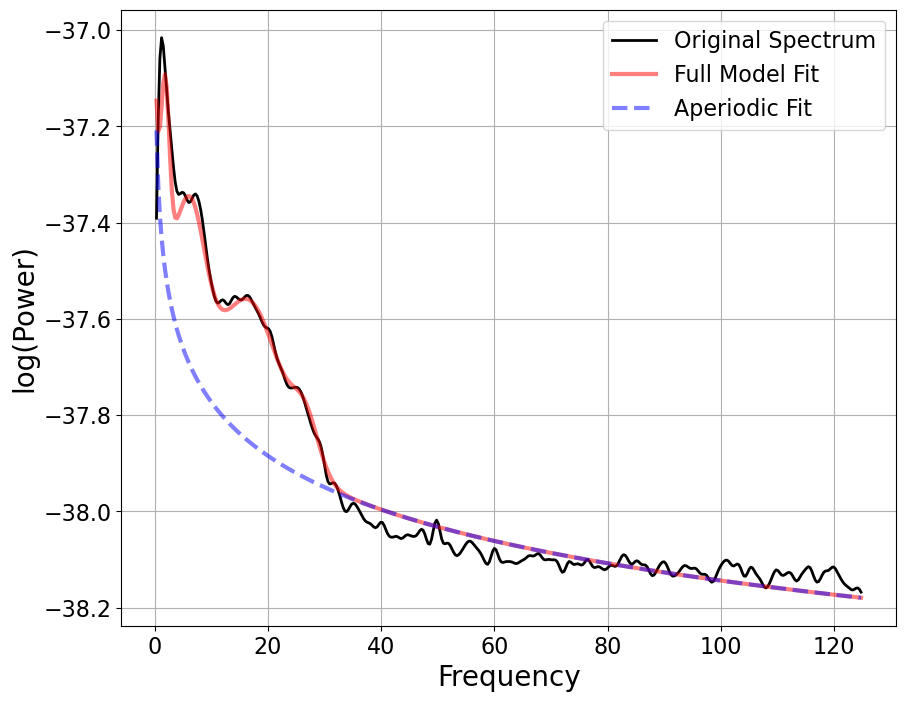

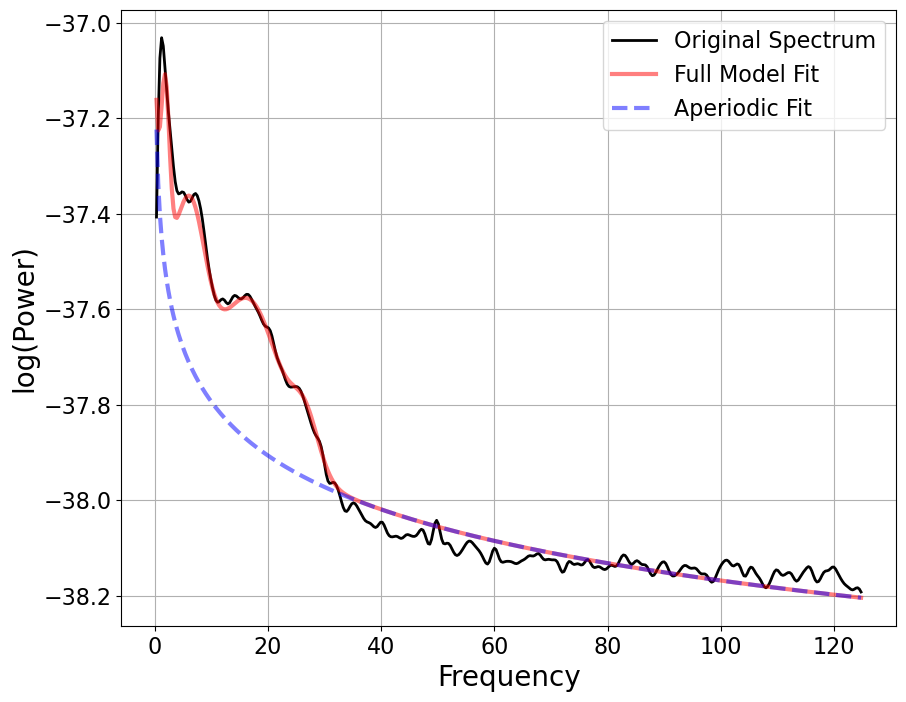

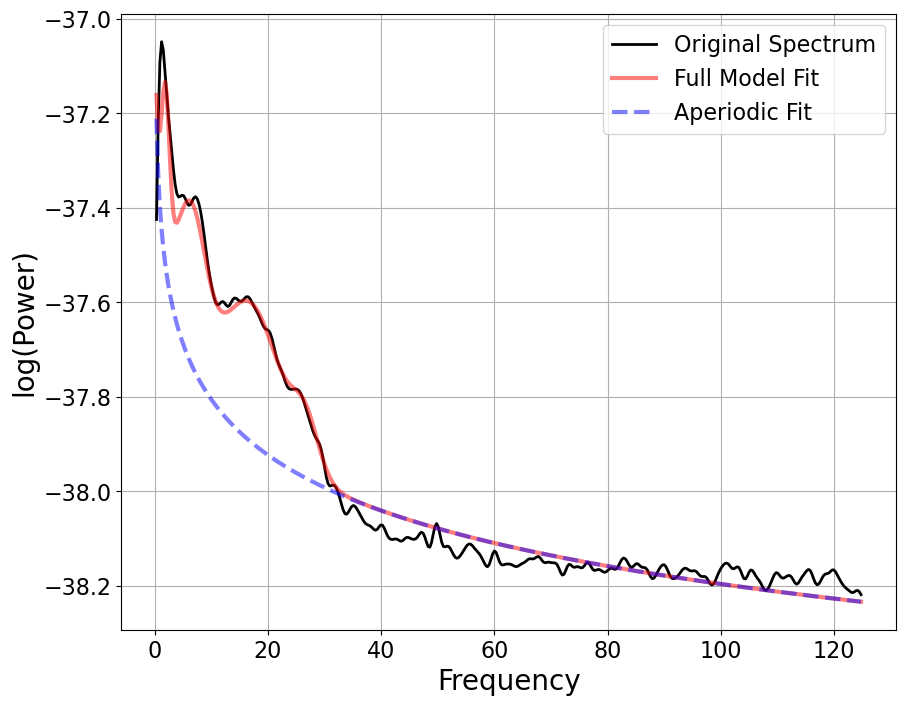

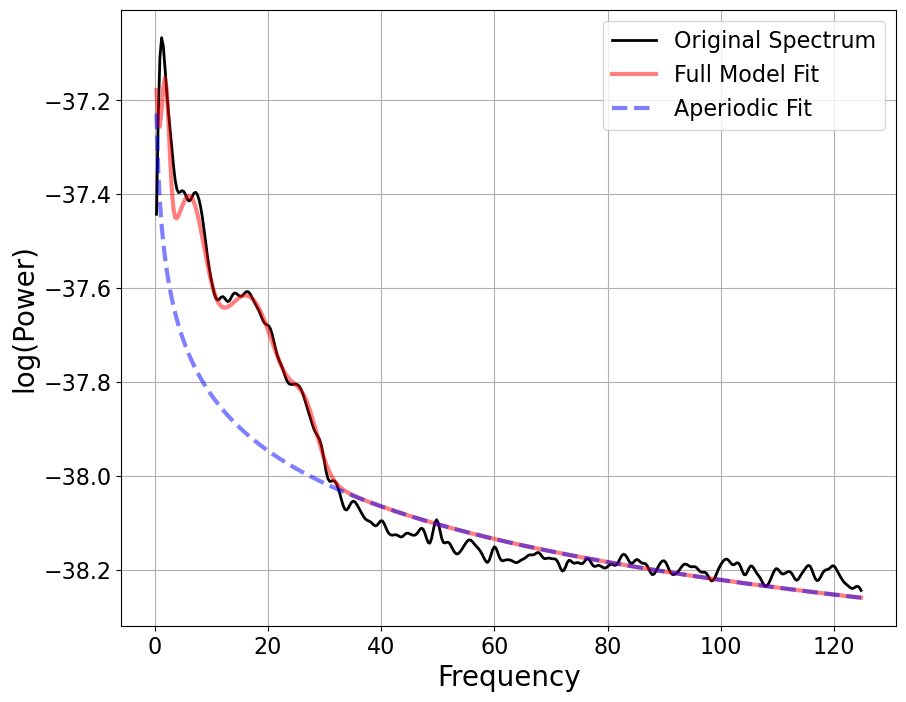

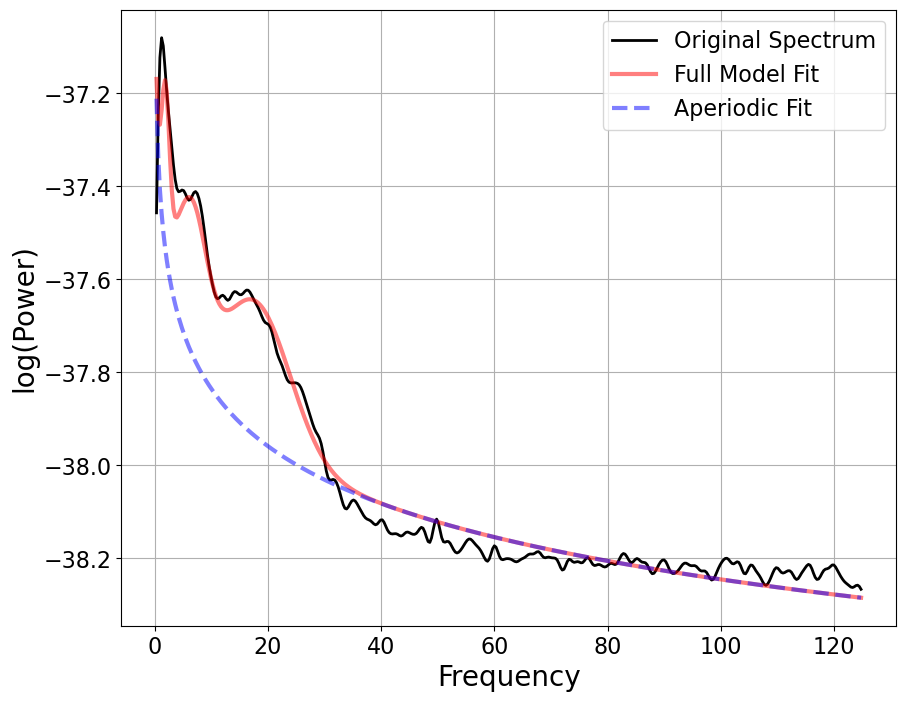

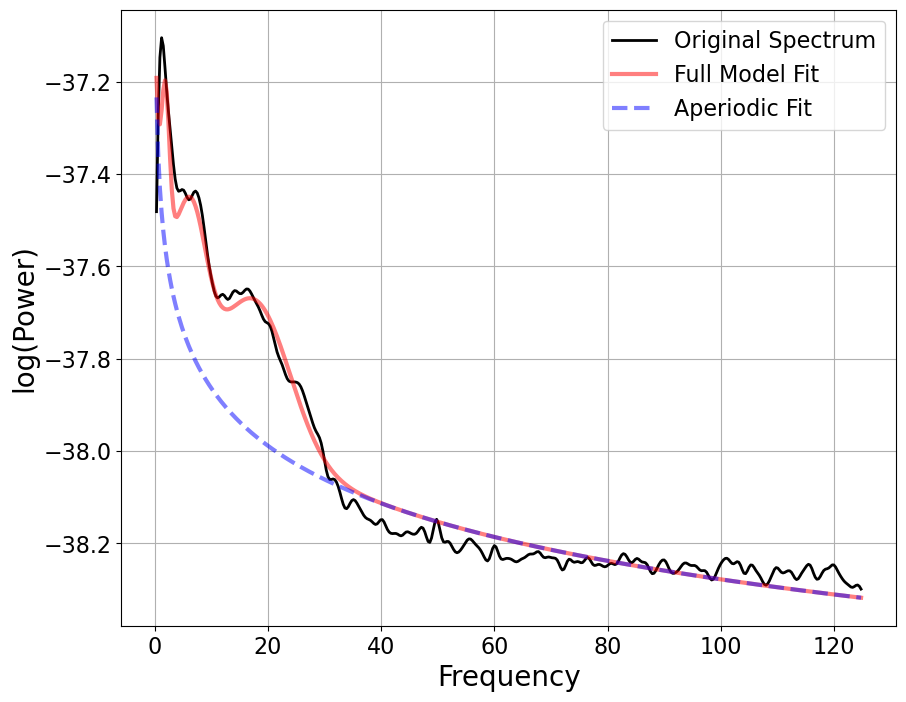

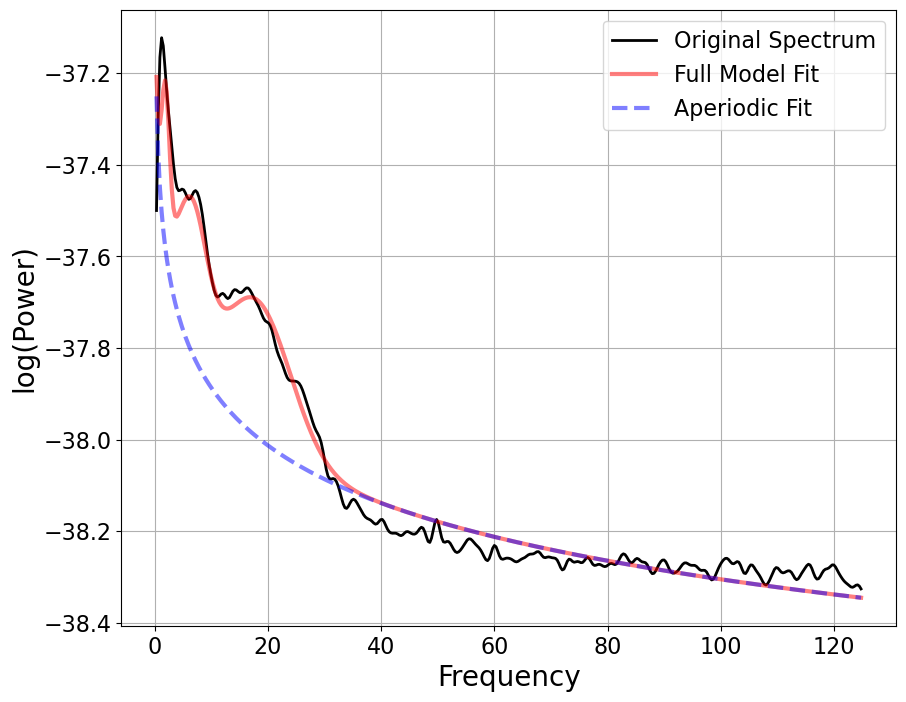

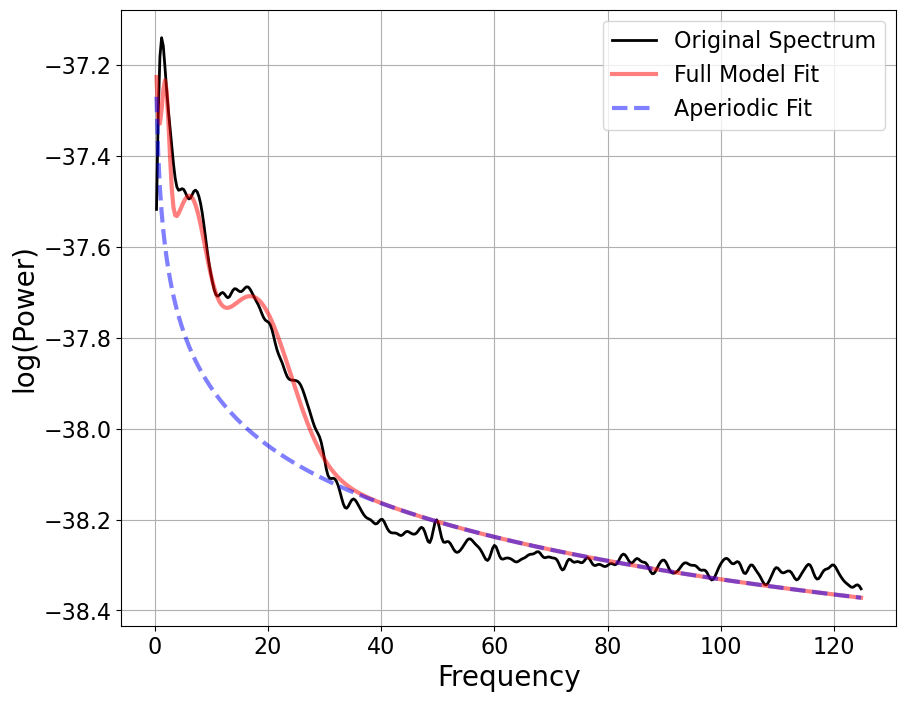

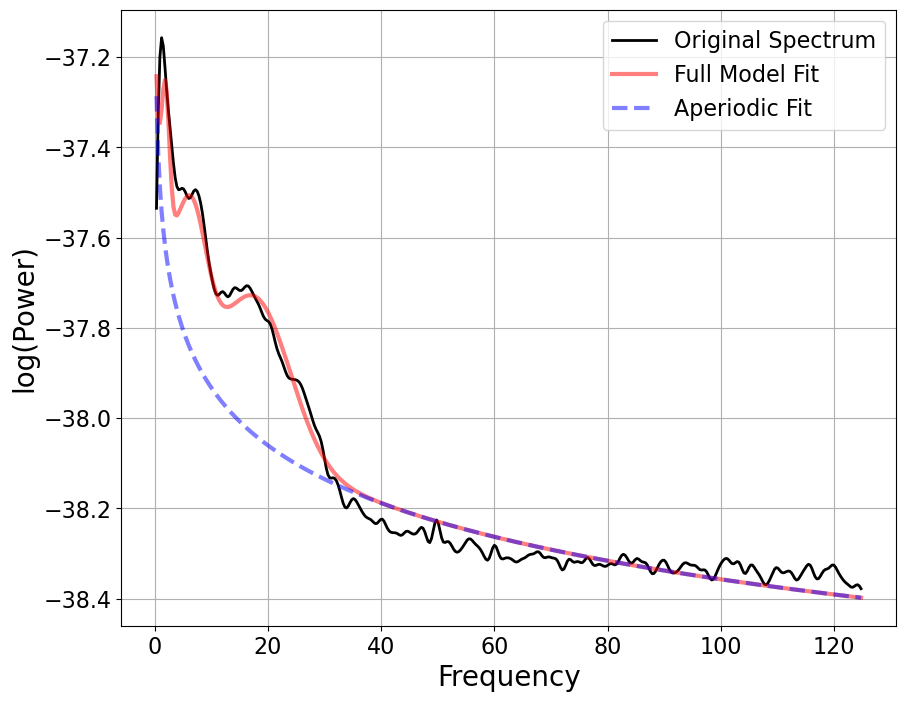

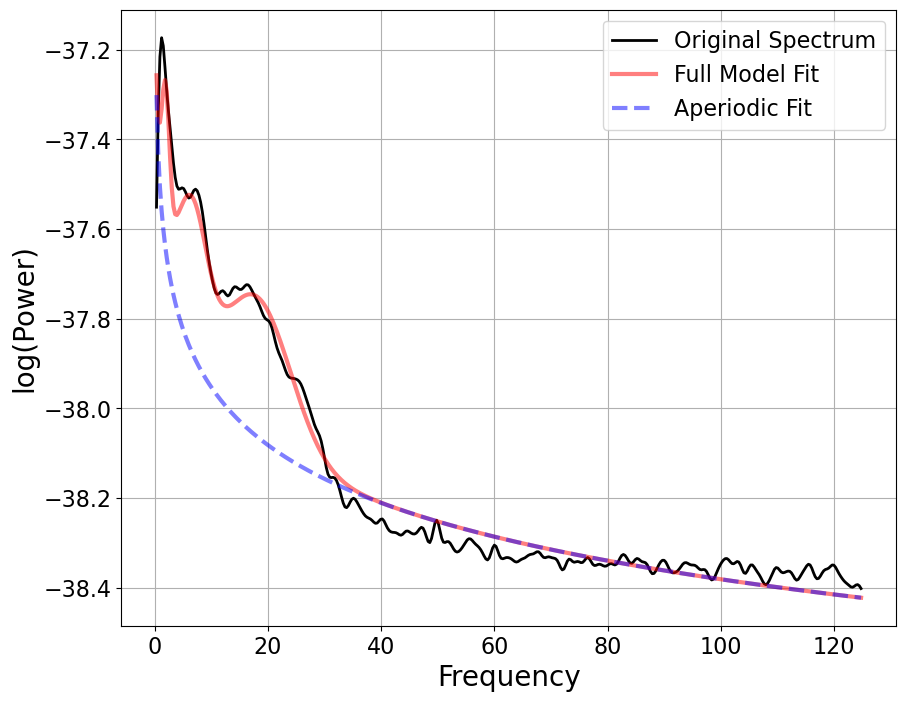

In [165]:
surf_psds=[]
surf_erps=[]
for i in range(n_surfs):
    surf_peak_idx=i*verts_per_surf+peak_idx

    tcs=np.zeros((epo_data.shape[0],epo_data.shape[2]))
    for t in range(epo_data.shape[0]):
        vert_tcs=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),epo_data[t,:,:])
        tcs[t,:]=vert_tcs
    surf_erps.append(np.mean(tcs,axis=0))
        
    winsize=int(epochs.info['sfreq'])
    overlap=int(winsize/2)    

    (psd,freqs)=psd_array_welch(tcs,
                                epochs.info['sfreq'], 
                                fmin=0.1, fmax=125, n_fft=2000,
                                n_overlap=overlap, n_per_seg=winsize, window='hann')
#     psd, freqs=psd_array_multitaper(tcs, sfreq=epochs.info['sfreq'], fmin=0, fmax=125, 
#                                          n_jobs=-1) 
    mean_psd=np.nanmean(psd,axis=0)
    surf_psds.append(mean_psd)
surf_psds=np.array(surf_psds)
surf_erps=np.array(surf_erps)

fg=FOOOFGroup(aperiodic_mode='fixed')
fg.fit(freqs,surf_psds, [0.1,125])
surf_aperiodic=np.zeros((n_surfs,len(freqs)))
surf_periodic=np.zeros((n_surfs,len(freqs)))
for i in range(n_surfs):
    fm = fg.get_fooof(ind=i, regenerate=True)
    fm.plot()
    ap_params=fm.get_params('aperiodic_params')
    surf_aperiodic[i,:] = gen_aperiodic(freqs, ap_params)
    surf_periodic[i,:]=np.log10(surf_psds[i,:])-surf_aperiodic[i,:]

In [166]:
rel_power=compute_rel_power(surf_psds, freqs)
rel_per_power=compute_rel_power(surf_periodic, freqs)    
rel_aper_power=compute_rel_power(surf_aperiodic, freqs)
crossover=get_crossover(freqs,rel_per_power,rel_aper_power)

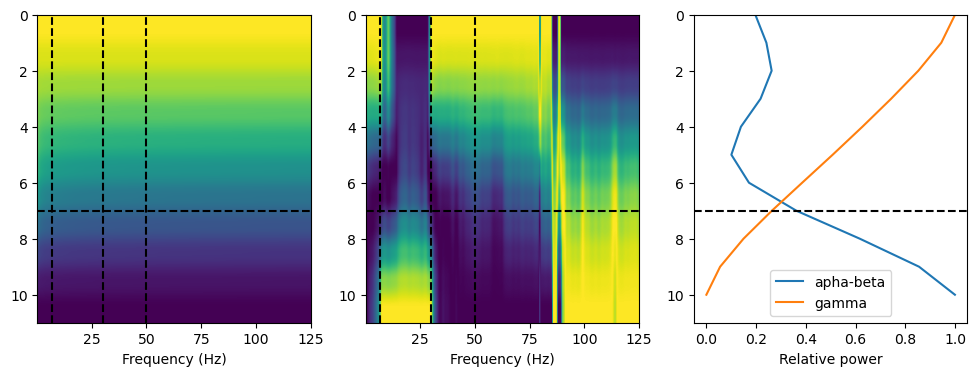

In [188]:
fig=plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
ax.imshow(rel_aper_power,aspect='auto',extent=[freqs[0],freqs[-1],n_surfs,0], origin='upper')
ax.set_xlabel('Frequency (Hz)')
xl=[freqs[0], 125]
ax.plot(xl,[crossover, crossover],'--',color='k')
ax.set_xlim(xl)
yl=ax.get_ylim()
ax.plot([7,7],yl,'k--')
ax.plot([30,30],yl,'k--')
ax.plot([50,50],yl,'k--')   

ax=plt.subplot(1,3,2)
ax.imshow(rel_per_power,aspect='auto',extent=[freqs[0],freqs[-1],n_surfs,0], origin='upper')
ax.set_xlabel('Frequency (Hz)')
xl=[freqs[0], 125]
ax.plot(xl,[crossover, crossover],'--',color='k')
ax.set_xlim(xl)
yl=ax.get_ylim()
ax.plot([7,7],yl,'k--')
ax.plot([30,30],yl,'k--')
ax.plot([50,50],yl,'k--')

ax=plt.subplot(1,3,3)
ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]
ab_rel_pow = np.mean(rel_per_power[:, ab_idx], axis=1)
g_rel_pow = np.mean(rel_aper_power[:, g_idx], axis=1)
ax.plot(ab_rel_pow,np.arange(rel_power.shape[0]),label='apha-beta')
ax.plot(g_rel_pow,np.arange(rel_power.shape[0]),label='gamma')
ax.set_ylim([rel_per_power.shape[0],0])
xl=ax.get_xlim()
ax.plot(xl,[crossover, crossover],'--',color='k')
ax.set_xlim(xl)
ax.set_xlabel('Relative power')
ax.legend()

In [185]:
csd=compute_csd(surf_erps, epochs.times, mean_dist, n_surfs)
csd_smooth=smooth_csd(csd, n_surfs)

base_idx=np.where(epochs.times<-0.25)[0]
base_csd=np.mean(csd_smooth[:,base_idx],axis=1)
csd_smooth=csd_smooth-base_csd[:,np.newaxis]

(-0.5, 0.5)

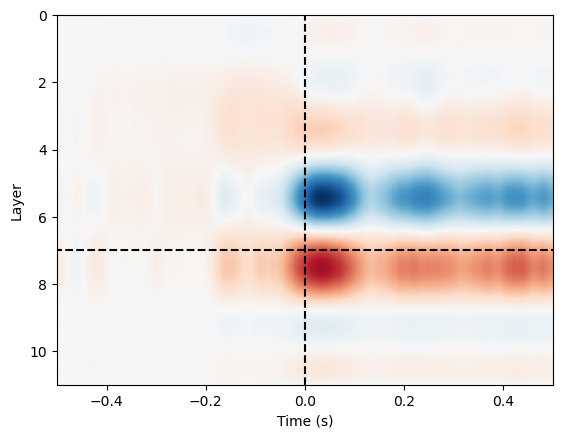

In [187]:
fig=plt.figure()
ax=plt.subplot(1,1,1)
vmin=-np.max(np.abs(csd_smooth[:]))
vmax=np.max(np.abs(csd_smooth[:]))
divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
levels=np.linspace(vmin,vmax,100)
im=ax.imshow(csd_smooth,cmap='RdBu_r',norm=divnorm, aspect='auto',
             extent=[epochs.times[0],epochs.times[-1],n_surfs,0],
             origin='upper')
yl=ax.get_ylim()
ax.plot([0, 0], yl,'--',color='k')
ax.set_ylim(yl)
xl=ax.get_xlim()
ax.plot(xl,[crossover, crossover],'--',color='k')
# ax.set_xlim(xl)
ax.set_ylabel('Layer')
ax.set_xlabel('Time (s)')
ax.set_xlim([-.5,.5])

array([-2.        , -1.99833333, -1.99666667, ...,  1.99666667,
        1.99833333,  2.        ])